# Detecting seismic anomalies under Red Square

This notebook is devoted to detecting and displaying seismic anomalies detected by the University of Washington Photonic Sensing Lab. A fiber optic cable connects UW Seattle to UW Bothell and runs the length of the city of Seattle, allowing our lab to detect ground moiton. While searching for signals generated by trains moving through underground tunnels in order to audit their schedule, we detected several strange high amplitude, low frequency events between the evening of November 10 thorugh the afternoon of November 14 under Red Square, the main plaza of the University of Washington Seattle campus.

It is currently unknown what is causing these signals as they span several channels of approximately 6 meter spacing per channel and do not always have similar features. An early hypothesis suggested these could be percussive signals from a nearby marching band or similar performance, however the events occur throughout the day and are non-dispersive. A percussive signal should be detected farther along the cable and be dispersive, however these detected signals are confined to only a few channels.

These signals are also accompanied by long "ring-down" time after detecting extremely large amplitudes as if the cable were kicked or picked up. There are also periods of extended shaking of several minutes as if a jackhammer is being operated right next to the cable. A likely candidate for these signals could easily be construction or maintenance in the parking garage below Red Square. 

Two suggested next steps for this project would be to:
1: Perform a tap test in or under Red Square to precisly locate the cable location.
2: Review facilities maintenance records for the parking garage in case of heavy machinery is being used.

These anomalies were found by running the rs_anomaly.py script. This script uses a nested for loop to run through repeating 10 minute windows of DAS data over 24 hours for 4 days. When large amplitudes are detected the data is filtered in two bandpass filters (0.01 - 0.1 Hz and 0.1 - 1 Hz) and a figure of the data is generated in space and time with color representing intensity. These figures allow us to select a specific channel to create a time series of the data, which reveals ring-down signals that can last for over a minute. 

In [1]:
#  import sys
# !{sys.executable} -m pip install tqdm
import os
from tqdm import tqdm
from dasquakes import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
def rs_anomaly_detector(
    cable = 'seadasn',
    record_length = 10,
    t0 = datetime.datetime(2022, 11, 11, 0, 16-1, 0),
    lower_freq1 = .01,
    upper_freq1 = .1,
    lower_freq2 = .1,
    upper_freq2 = 1,
    lower_chan = 65,
    upper_chan = 80,
    vm = 50,
    selected_channel = 9
):
#     t0 = datetime.datetime(2022, 11, day, 0 + hour, minute, 0)
    #         print(t0)


    prefix, network_name, datastore = data_wrangler(cable, record_length, t0)

    data, dates, attrs = open_sintela_file(
         prefix,
         t0,
         datastore,
         number_of_files=record_length,
         verbose=False
    )

    
    nt = data.shape[0]
    nx = data.shape[1]
    data_subset = data[:, lower_chan:upper_chan]
    fs = 2 * attrs['MaximumFrequency']
    
    y_max = len(data_subset) / 100


    b,a = butter(2,[lower_freq1, upper_freq1],'bandpass',fs = fs)
    d,c = butter(2,[lower_freq2, upper_freq2],'bandpass',fs = fs)

    data_subset_filtered1 = filtfilt(b,a,data_subset,axis=0)
    data_subset_filtered2 = filtfilt(d,c,data_subset,axis=0)


    time_change = datetime.timedelta(hours = -8)
    minute_change = datetime.timedelta(minutes = record_length)
    new_time = t0 + time_change
    time_end = t0 + time_change + minute_change



    if data_subset.max() >= 30:
        fig, axs = plt.subplots(
            2, 3, figsize = (20,20), gridspec_kw={'height_ratios': [3, 1]}
        )
        # unfiltered data
        axs[0,0].imshow(
            data_subset,
            aspect = 'auto',
            vmin = -vm,
            vmax = vm,
            extent = (int(lower_chan), int(upper_chan), y_max, 0)
        )
        axs[0, 0].set_title(
                'Raw Data'  '\n' +
                str(new_time) +
                ' - ' + 
                str(time_end.time()),
                fontsize = '22'
            )
        axs[0,0].tick_params(axis='both', labelsize=22)
        axs[0,0].set_ylabel('Time (s)', fontsize = '22')
        axs[0,0].set_xlabel('Channel', fontsize = '22')


        # filtered data
        axs[0,1].imshow(
            data_subset_filtered1,
            aspect = 'auto',
            vmin = -vm,
            vmax = vm,
            extent = (lower_chan, upper_chan, y_max, 0)
        )
        axs[0, 1].set_title(
                'Filtered Data ' + str(lower_freq1) + ' - ' + 
                str(upper_freq1) + ' Hz\n' +
                str(new_time) +
                ' - ' + 
                str(time_end.time()),
                fontsize = '22'
            )
        axs[0, 1].set_ylabel('Time (s)', fontsize = '22')
        axs[0, 1].set_xlabel('Channel', fontsize = '22')
        axs[0,1].tick_params(axis='both', labelsize=22)


        # filtered data
        axs[0,2].imshow(
            data_subset_filtered2,
            aspect = 'auto',
            vmin = -vm,
            vmax = vm,
            extent = (lower_chan, upper_chan, y_max, 0)
        )
        axs[0, 2].set_title(
                'Filtered Data ' + str(lower_freq2) + ' - ' + 
                str(upper_freq2) + ' Hz\n' +
                str(new_time) +
                ' - ' + 
                str(time_end.time()),
                fontsize = '22'
            )
        axs[0, 2].set_ylabel('Time (s)', fontsize = '22')
        axs[0, 2].set_xlabel('Channel', fontsize = '22')
        axs[0,2].tick_params(axis='both', labelsize=22)


        timestamp_range = (pd.date_range(start=new_time,
                                        end = time_end,
                                       freq = 'min'))
        time_labels = []

        for i in timestamp_range:
            time_labels.append(str(i)[11:-3])

        N = 11
        ind = np.arange(N)      


        # unfiltered time series
        axs[1,0].plot(dates ,data_subset[:,selected_channel])

        axs[1,0].set_title(
                'Channel ' + str(65 + selected_channel) +' Time Series',
                fontsize = '22'
            )
        axs[1,0].tick_params(axis='both', labelsize=22)
        axs[1,0].set_xticklabels(time_labels)
        axs[1,0].tick_params(axis='x', labelrotation = 45)


        # filtered time series
        axs[1,1].plot(dates, data_subset_filtered1[:,selected_channel])
        axs[1,1].set_title('Channel ' + str(65 + selected_channel) +' Time Series',
                           fontsize = '22')
#             axs[1,1].tick_params(axis='both', labelsize=15)
        axs[1,1].tick_params(axis = 'both', labelsize = 22)
        axs[1,1].set_xticklabels(time_labels)
        axs[1,1].tick_params(axis='x', labelrotation = 45)


                    # filtered time series
        axs[1,2].plot(dates, data_subset_filtered2[:,selected_channel])
        axs[1,2].set_title('Channel ' + str(65 + selected_channel) +' Time Series',
                           fontsize = '22')
#             axs[1,1].tick_params(axis='both', labelsize=15)
        axs[1,2].tick_params(axis = 'both', labelsize = 22)
        axs[1,2].set_xticklabels(time_labels)
        axs[1,2].tick_params(axis='x', labelrotation = 45)

        fig.patch.set_facecolor('w')

        plt.locator_params(axis='y', nbins=15)
        axs[0,0].grid(color = 'red', which = 'both')
        axs[0,1].grid(color = 'red', which = 'both')
        axs[0,2].grid(color = 'red', which = 'both')

        plt.tight_layout()
        plt.show()

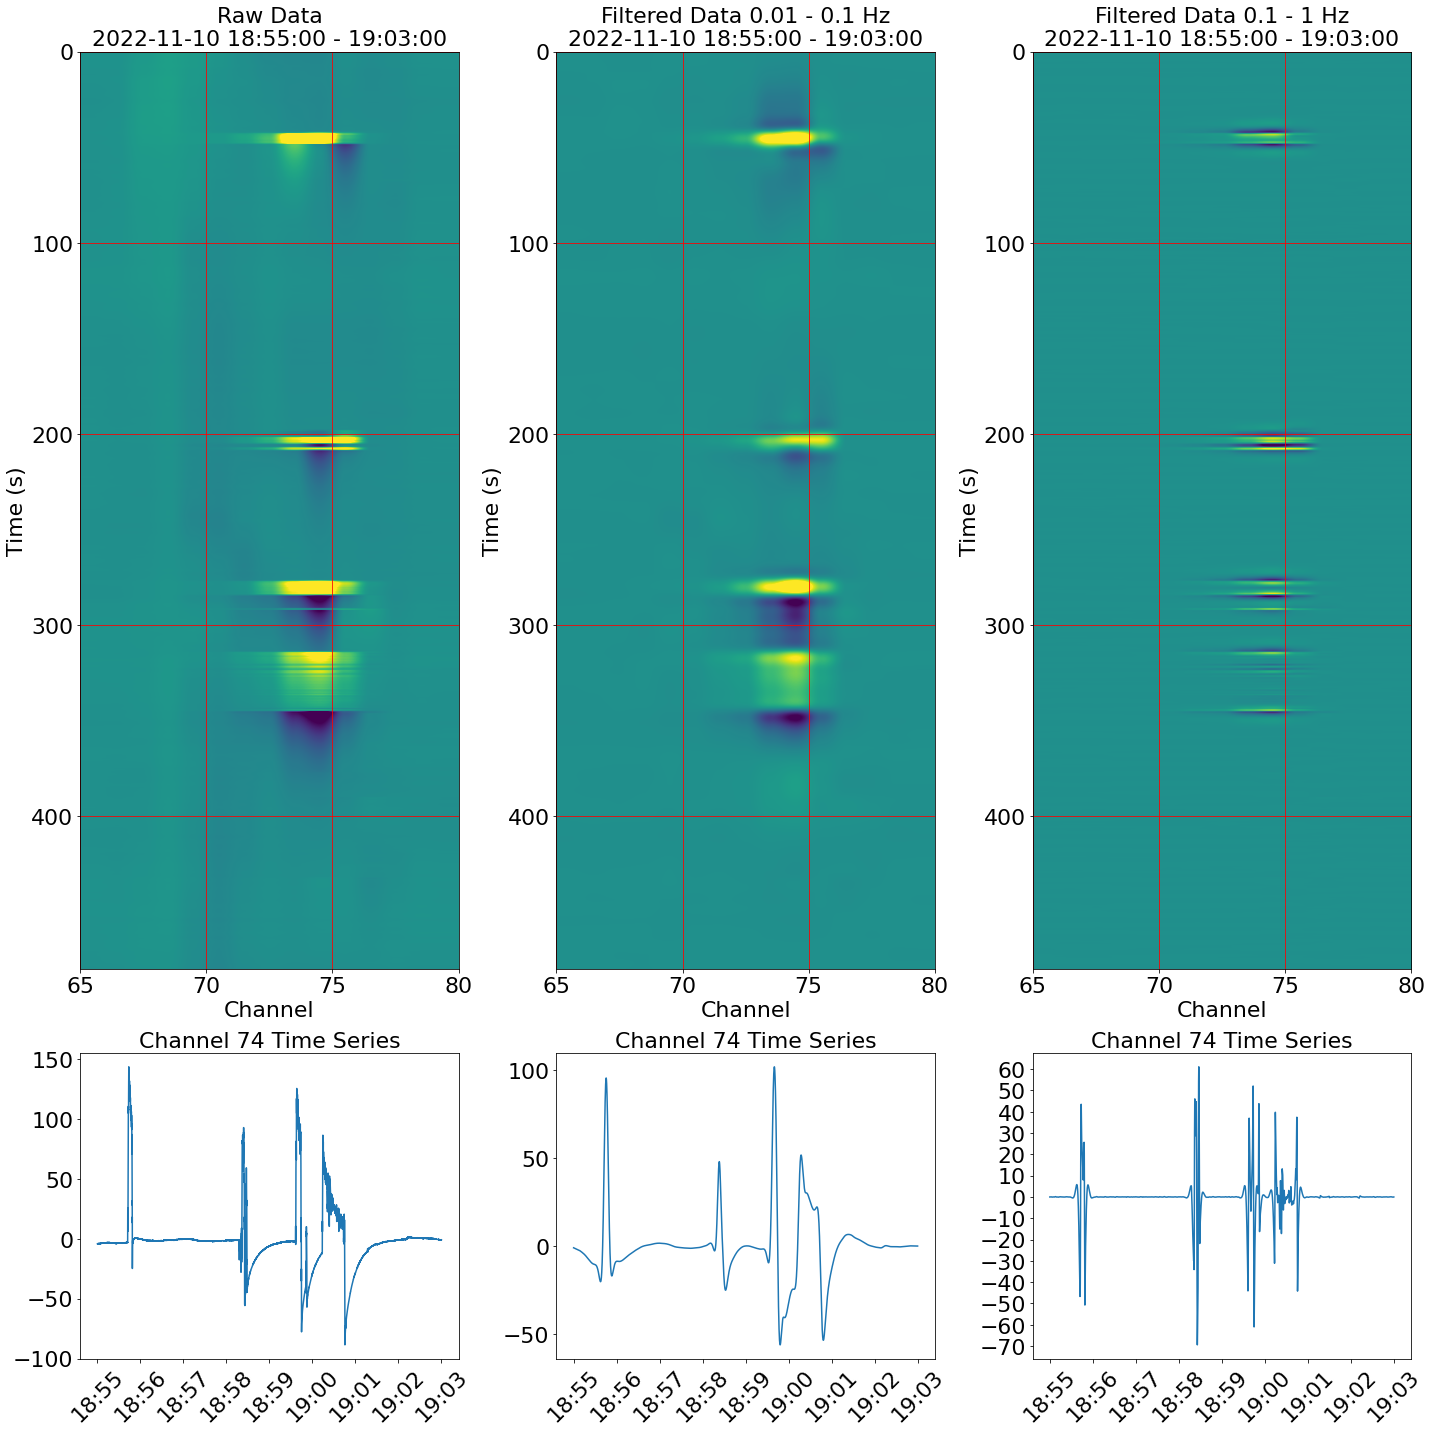

In [3]:
rs_anomaly_detector(
    record_length = 8,
    t0 = datetime.datetime(2022, 11, 11, 2, 55, 0),
    selected_channel = 9,
)

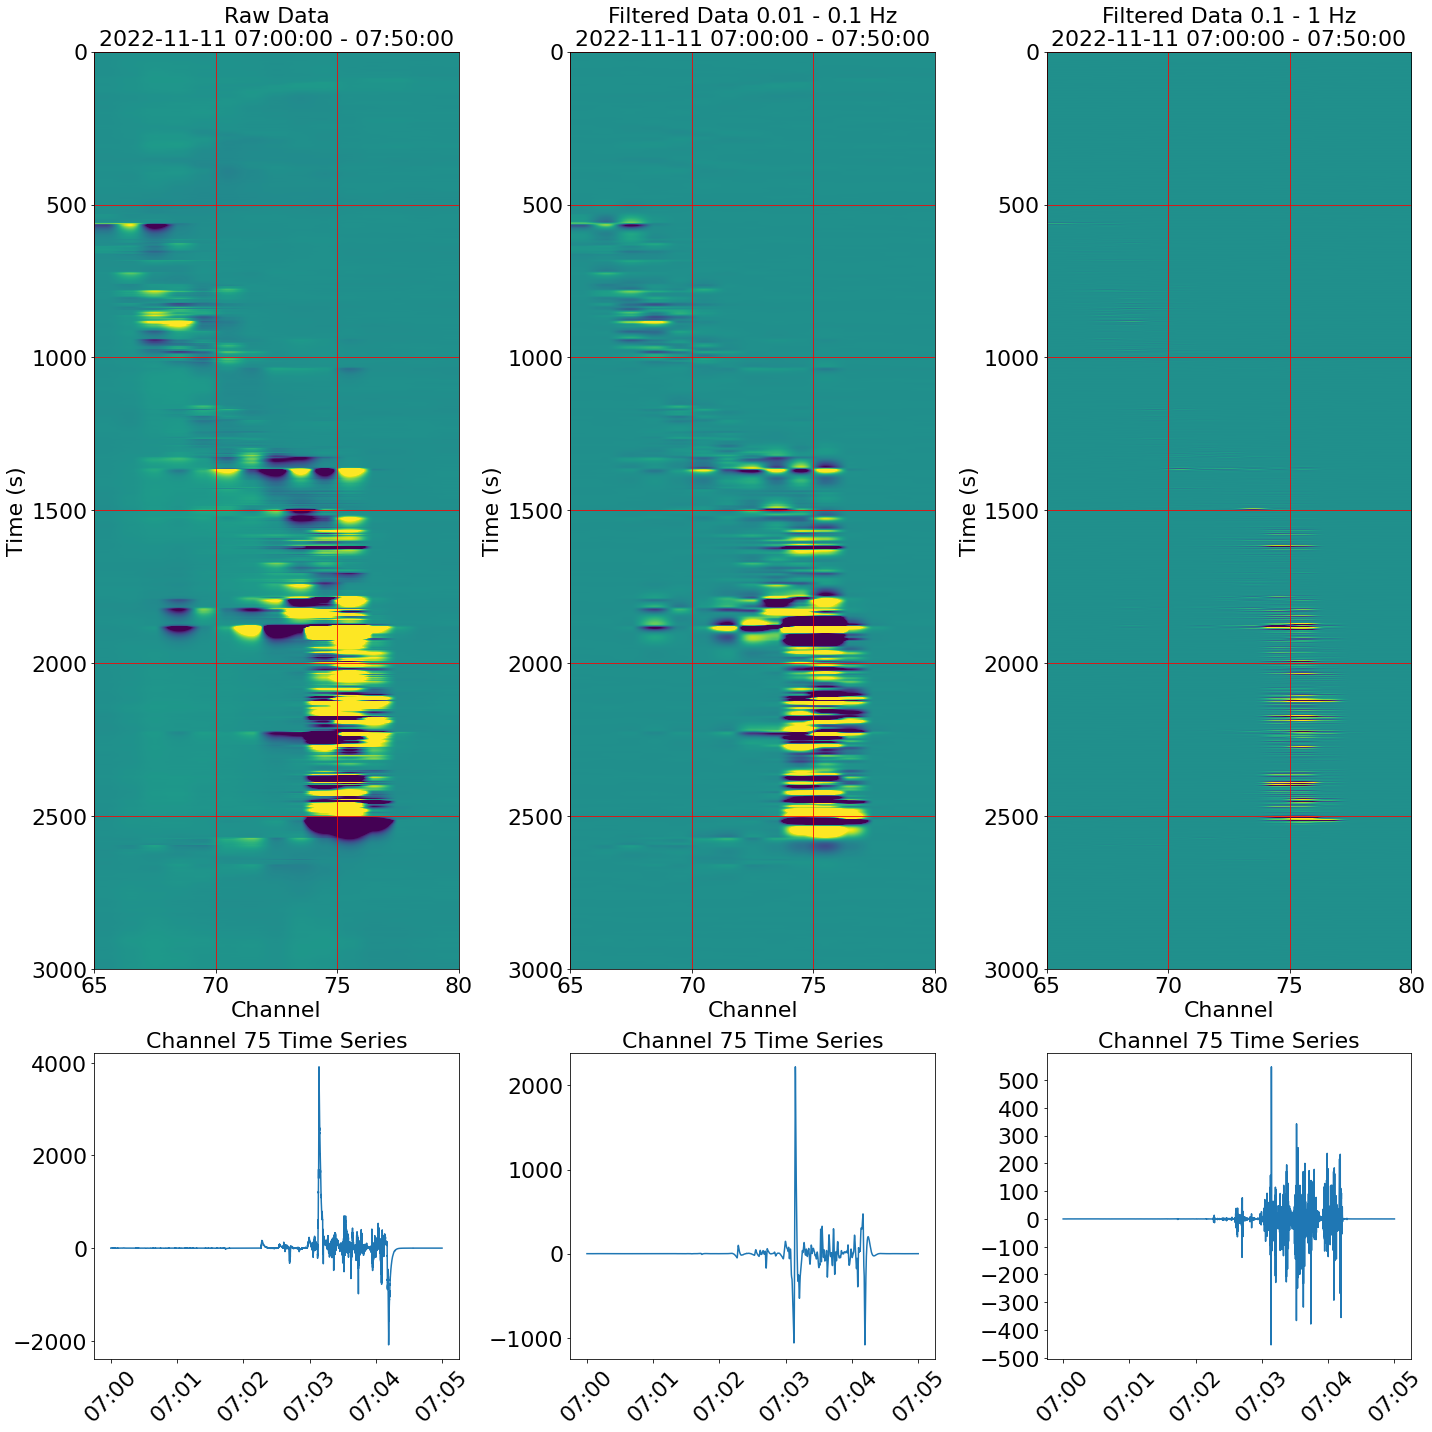

In [4]:
rs_anomaly_detector(
    record_length = 50,
    t0 = datetime.datetime(2022, 11, 11, 15, 0, 0),
    selected_channel = 10
)

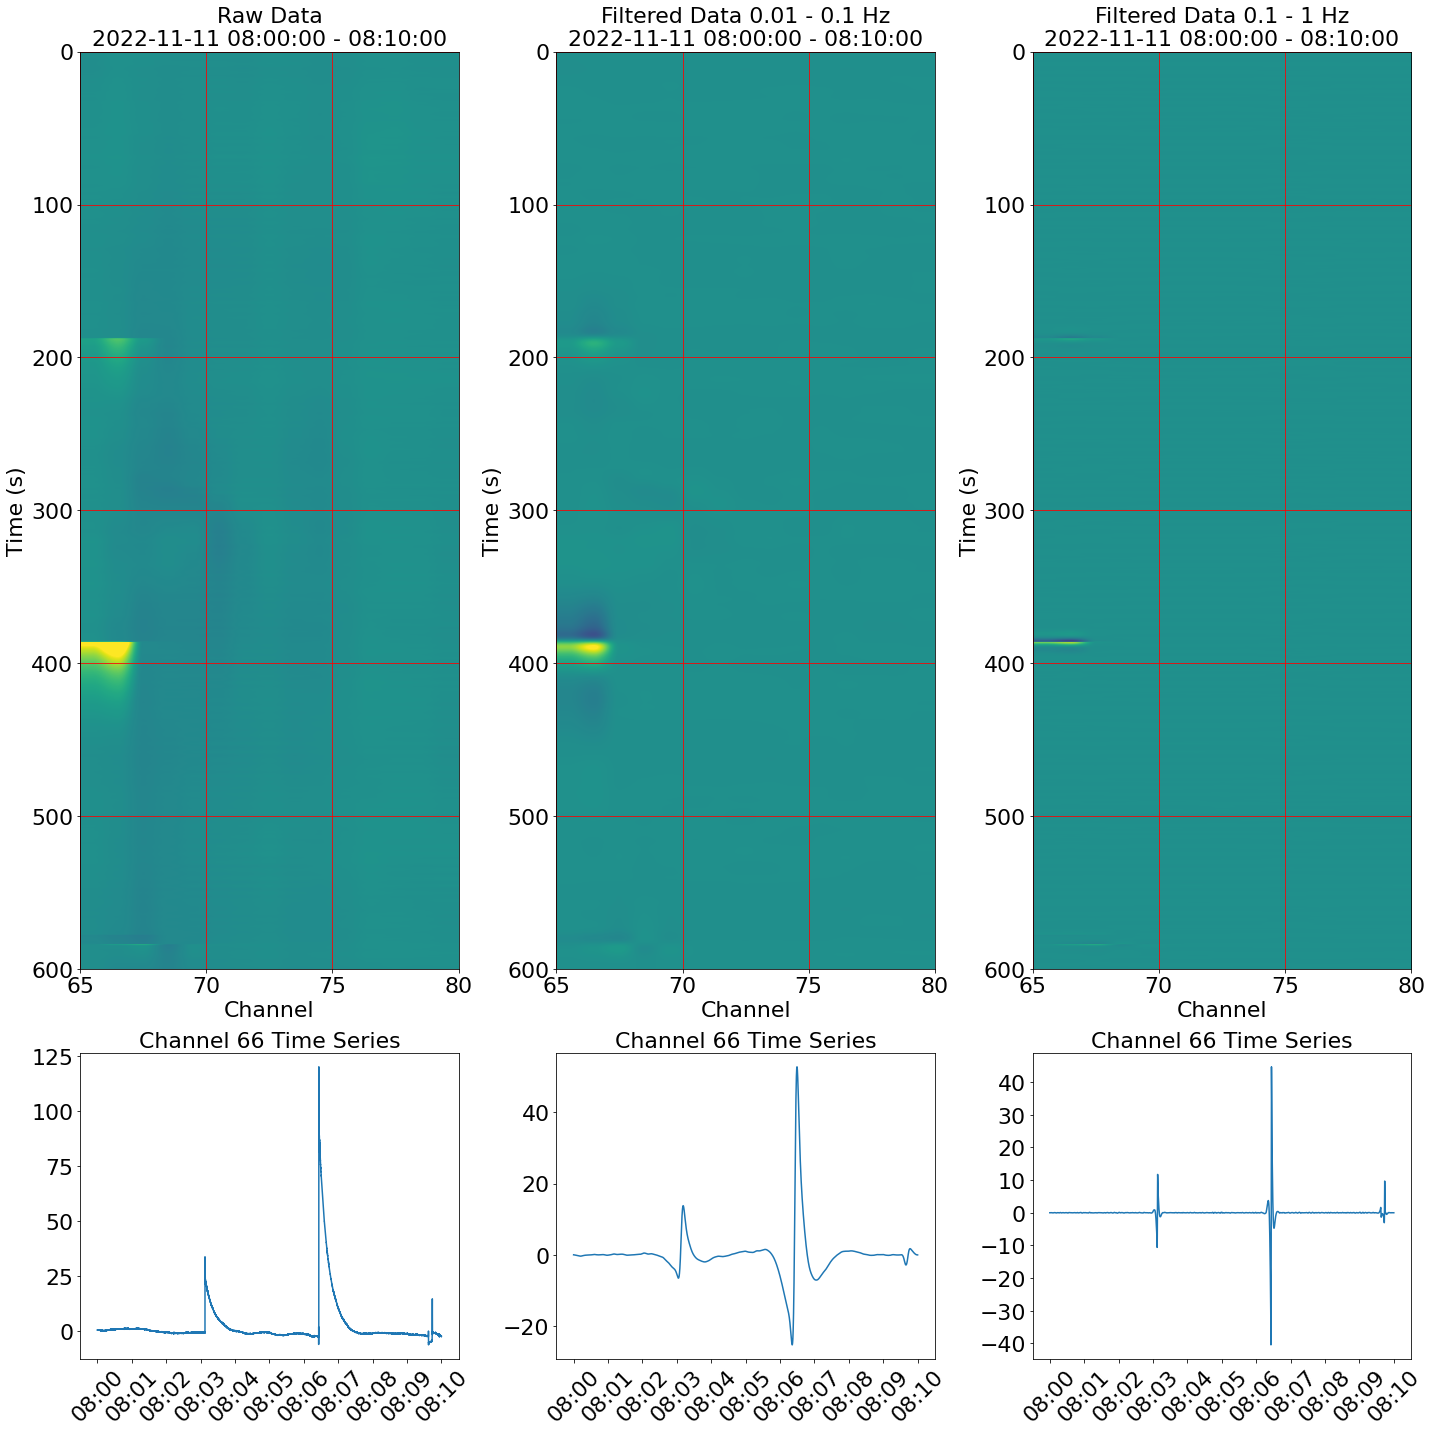

In [5]:
rs_anomaly_detector(
    t0 = datetime.datetime(2022, 11, 11, 16, 0, 0),
    selected_channel = 1
)

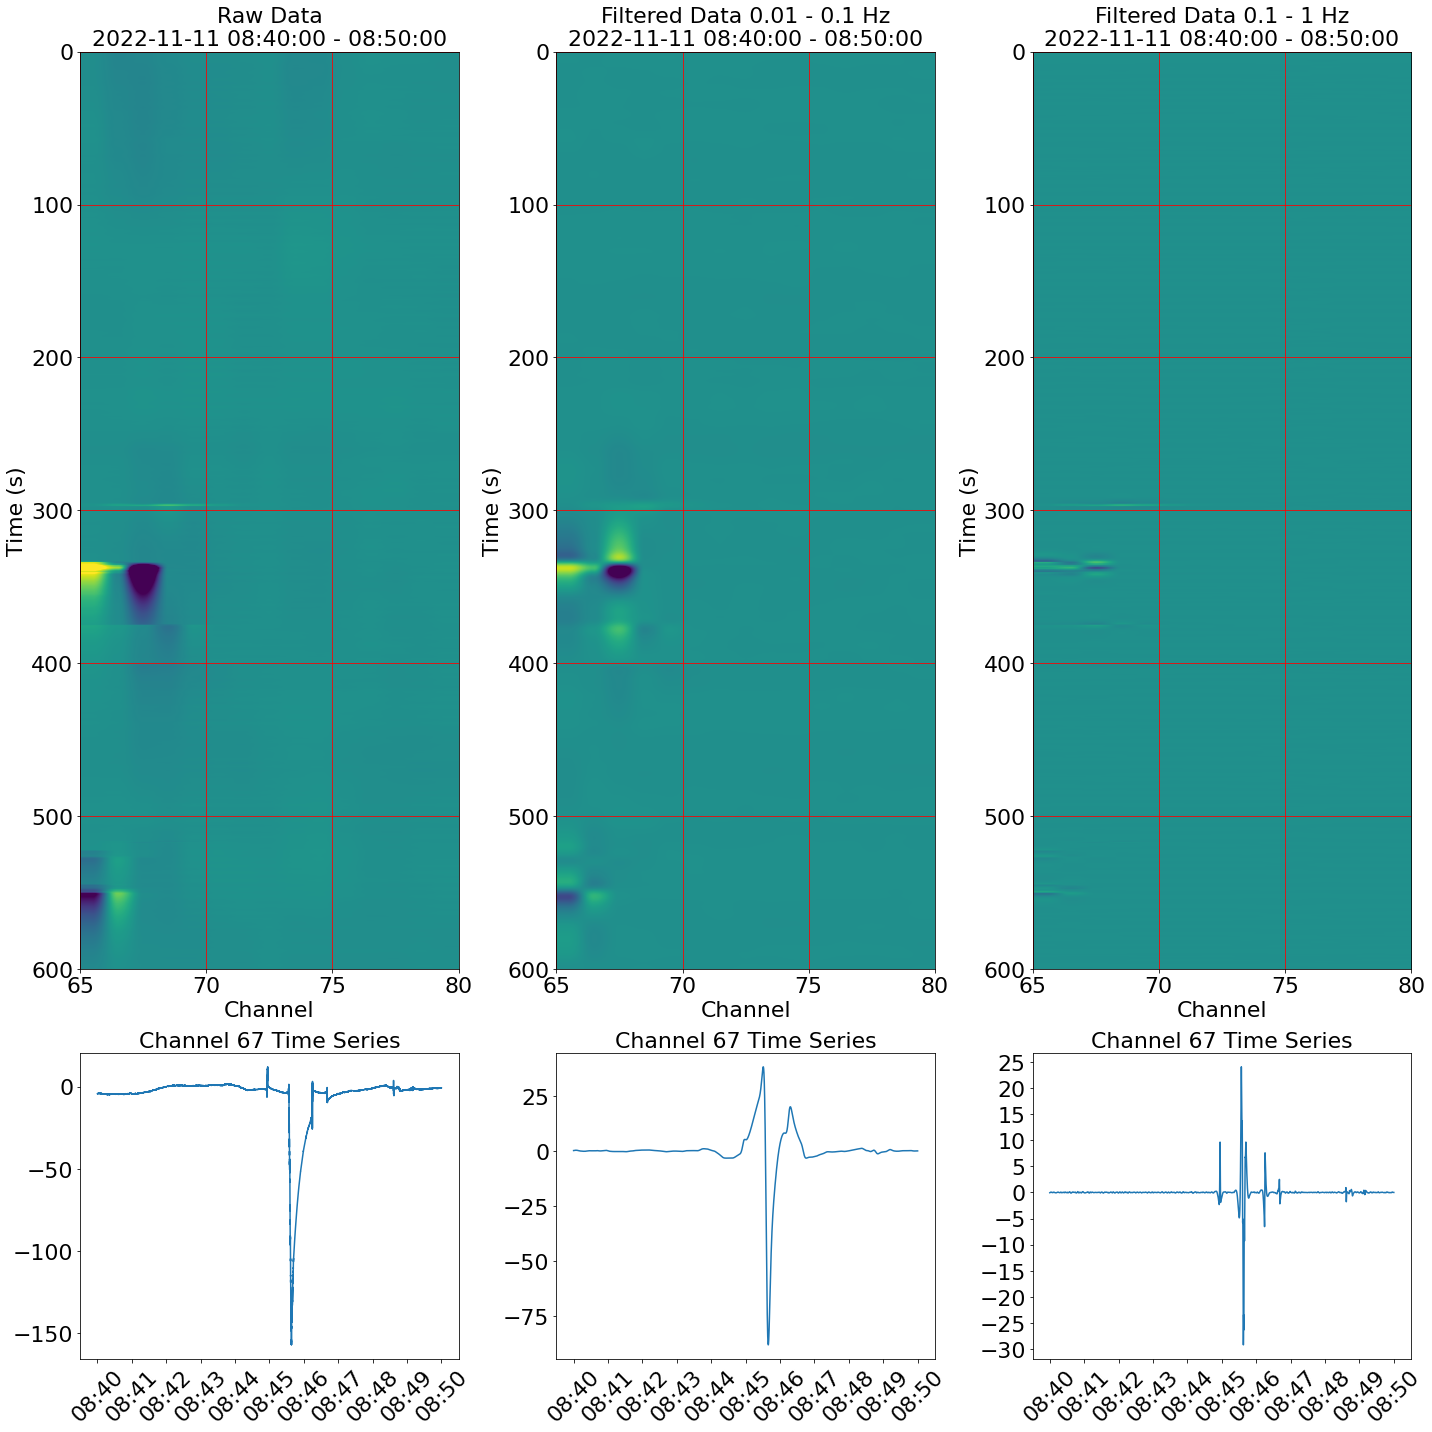

In [6]:
rs_anomaly_detector(
    t0 = datetime.datetime(2022, 11, 11, 16, 40, 0),
    selected_channel = 2
)

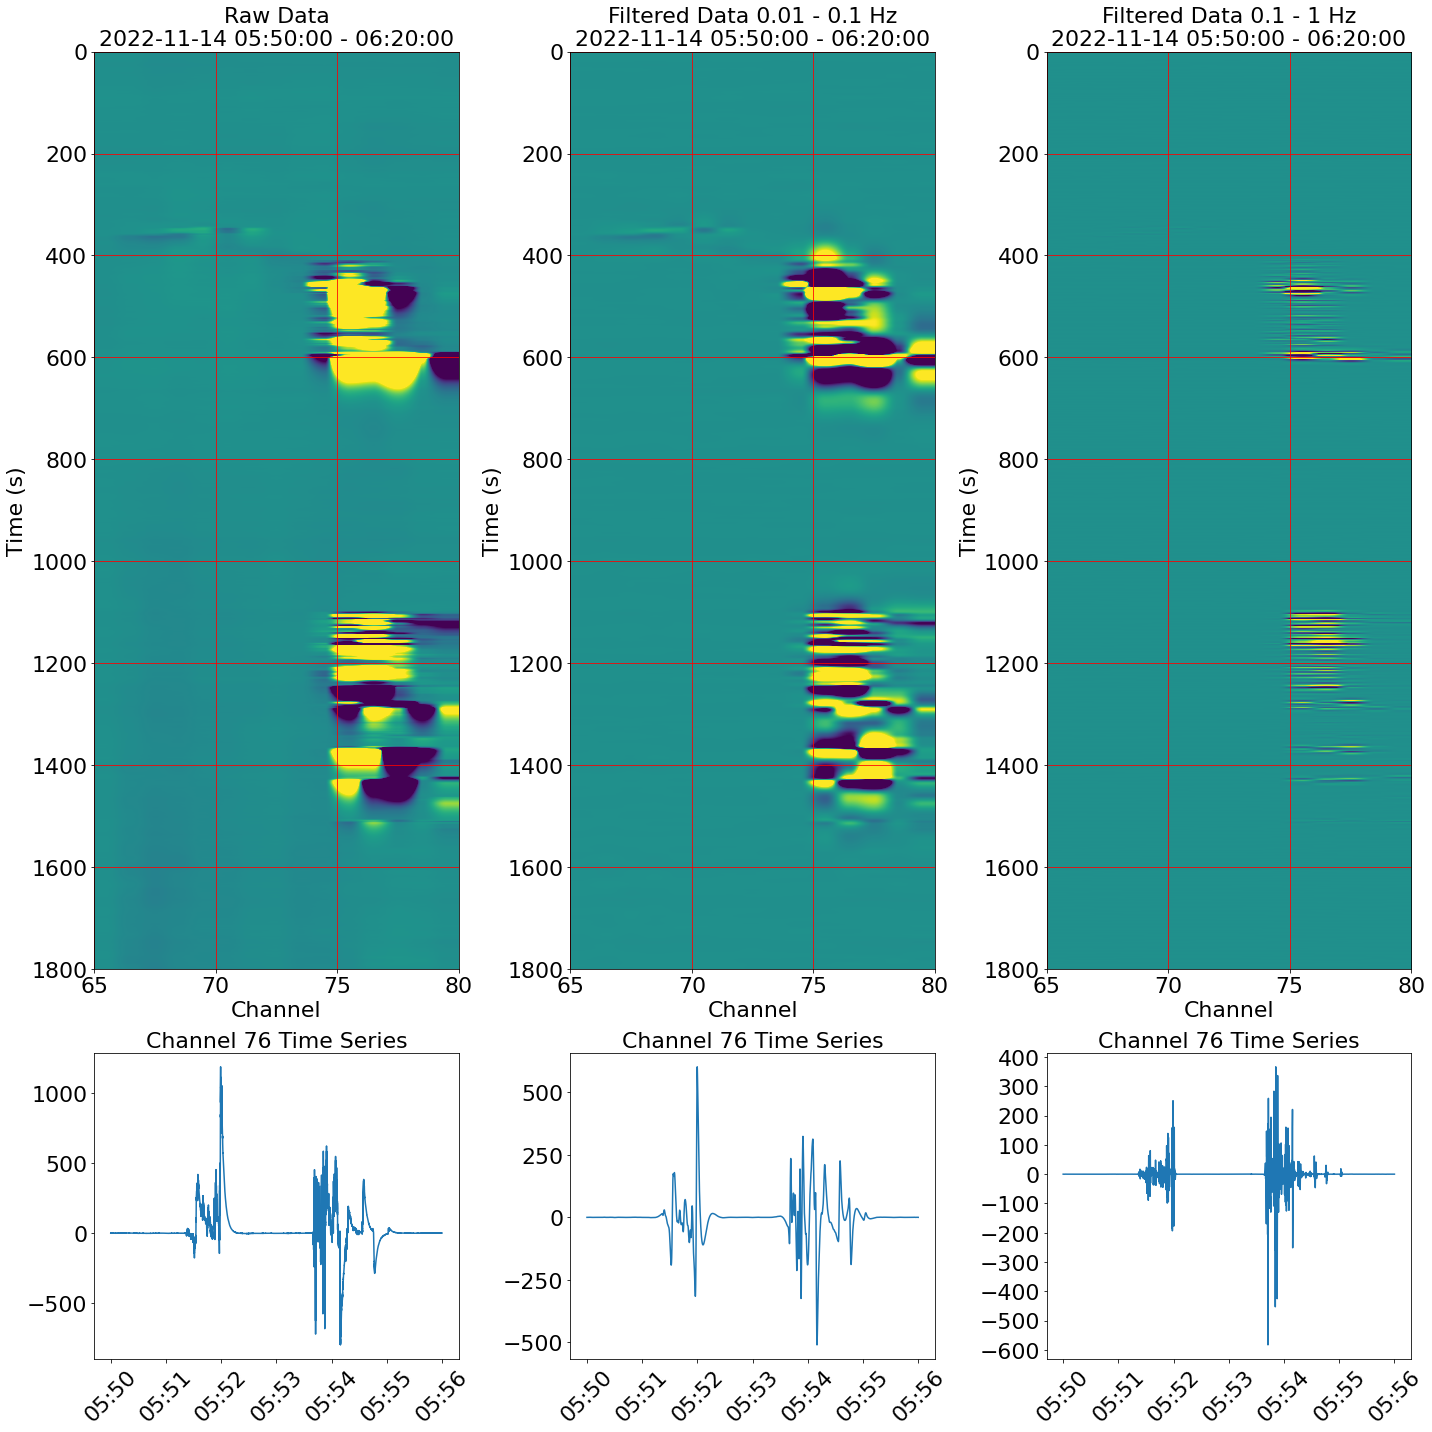

In [7]:
rs_anomaly_detector(
    record_length = 30,
    t0 = datetime.datetime(2022, 11, 14, 13, 50, 0),
    selected_channel = 11
)

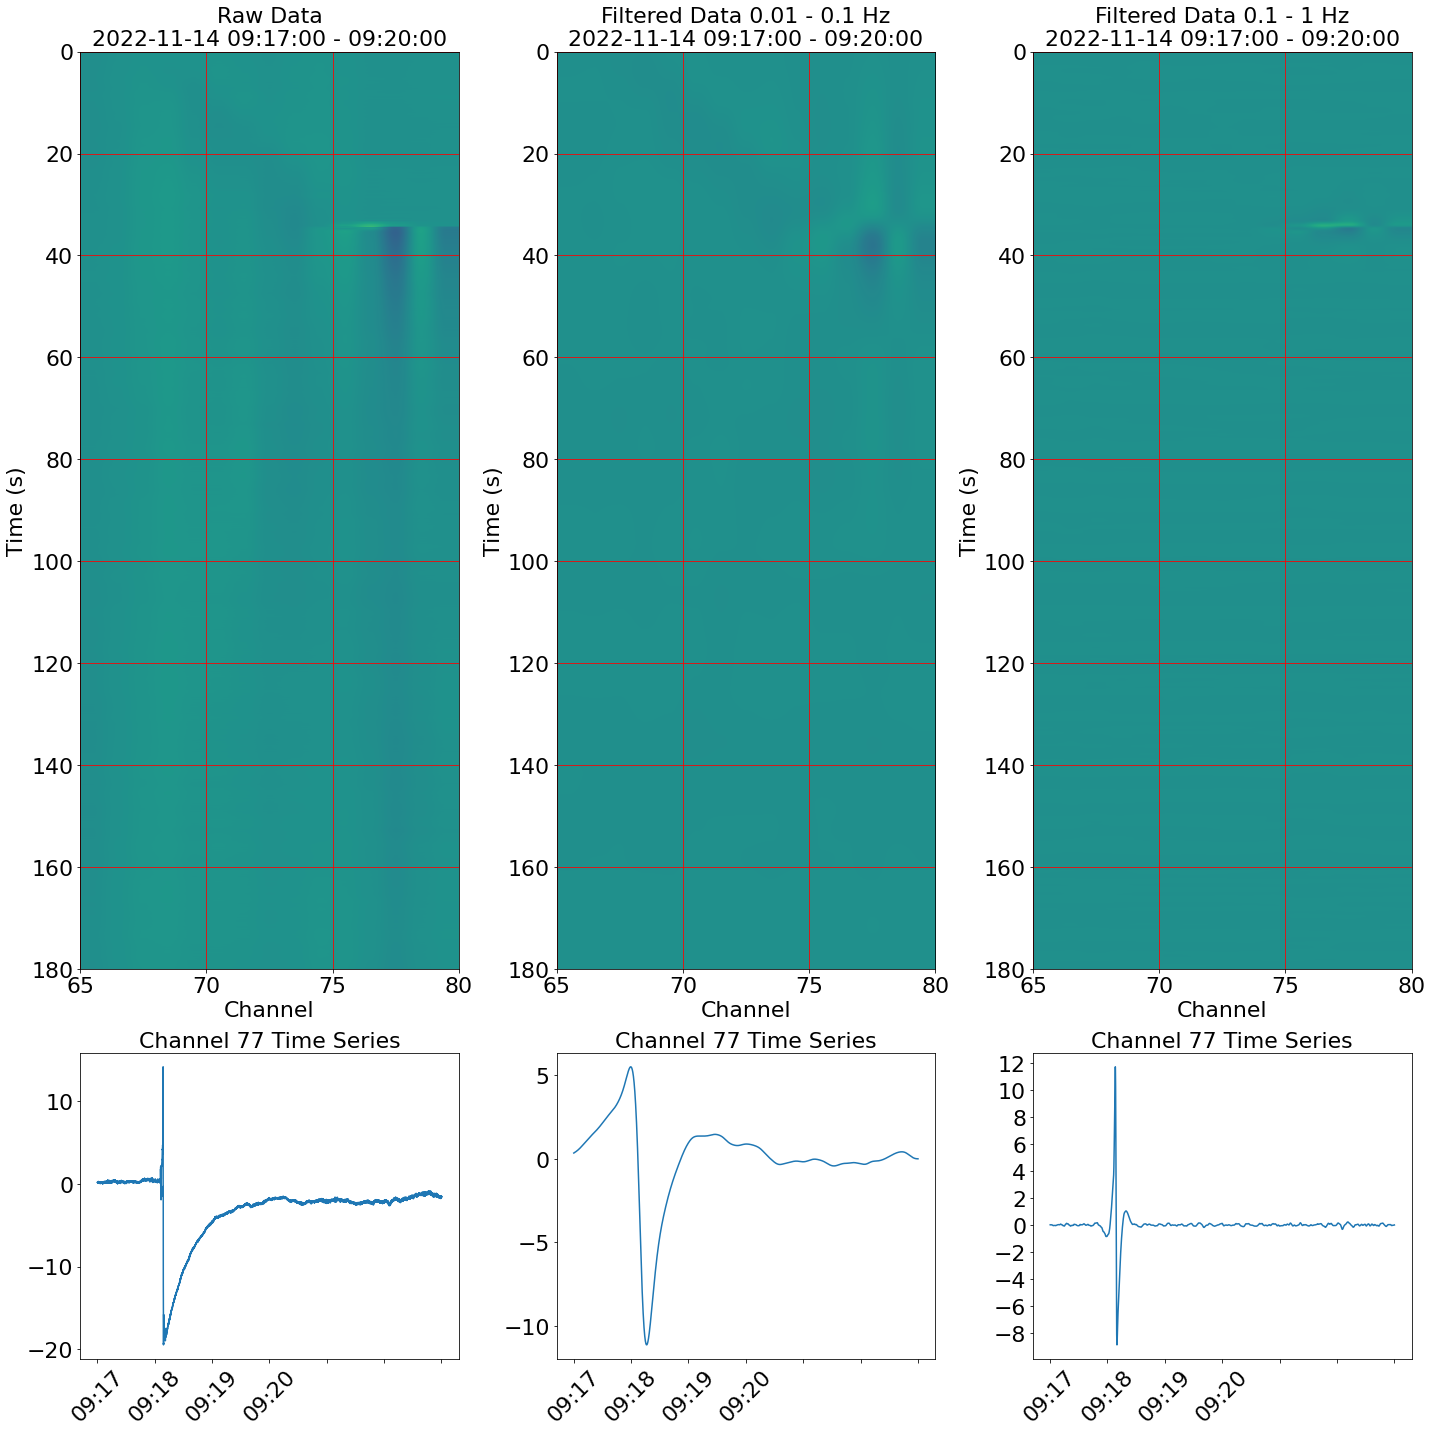

In [8]:
rs_anomaly_detector(
    record_length = 3,
    t0 = datetime.datetime(2022, 11, 14, 17, 17, 0),
    selected_channel = 12
)